In [1]:
# Importing all the necessary libraries
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import numpy as np
import math as math
import os
import seaborn as sns
from IPython.display import clear_output
from sklearn.neighbors import KernelDensity,KNeighborsClassifier
import os
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, StratifiedKFold, train_test_split
import pickle
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
import subprocess
import joblib
import requests
from PIL import Image
import matplotlib.patches as patches
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from collections import Counter
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
from astropy.io import fits
from specutils import Spectrum1D
from specutils.manipulation import resample
from specutils.analysis import line_flux, centroid
from specutils.fitting import fit_generic_continuum
from astropy.io import fits
from astropy import units as u
from pyraf import iraf
# import pyspeckit
from astropy.io import fits
from astroquery.irsa_dust import IrsaDust
from astropy.coordinates import SkyCoord
from dust_extinction.parameter_averages import CCM89
import astropy.units as u
from specutils.manipulation import resample, FluxConservingResampler, LinearInterpolatedResampler
from astropy.nddata import StdDevUncertainty
from specutils.analysis import line_flux, centroid
from specutils.fitting import fit_generic_continuum

# from RVSNUpy.spectrum_import import sdss_fits
# from RVSNUpy.rvm import rvm
# from RVSNUpy.template import sdss_galaxy_templates
# from RVSNUpy.spectrum_import import MMT_raw, sdss_fits

pd.set_option("display.max_rows", 300)
pd.set_option("display.max_columns", None)

SEED = 333
np.random.seed(SEED)


In [2]:
# Funções
def meus_espectros_para_rvsnu(wavelength, flux, uncertainty=None):
    """
    Converte seus espectros para o formato esperado pelo RVSNUpy
    
    Parameters:
    -----------
    wavelength : array
        Comprimento de onda em Angstroms
    flux : array  
        Fluxo (qualquer unidade)
    uncertainty : array, optional
        Incerteza no fluxo. Se None, será estimada
    
    Returns:
    --------
    spectrum : array (4, n_pixels)
        Espectro no formato RVSNUpy
    """
    
    # Garantir que são arrays numpy
    wavelength = np.array(wavelength)
    flux = np.array(flux)
    
    # Se não tem incerteza, estimar baseado no ruído do espectro
    if uncertainty is None:
        # Estimar incerteza como desvio padrão local
        from scipy.ndimage import uniform_filter1d
        smoothed = uniform_filter1d(flux, size=10)
        uncertainty = np.abs(flux - smoothed)
        uncertainty[uncertainty == 0] = np.nanstd(flux) * 0.1
    else:
        uncertainty = np.array(uncertainty)
    
    # Criar máscara (todos pixels válidos inicialmente)
    mask = np.ones_like(wavelength)
    
    # Mascarar pixels com problemas
    bad_pixels = (~np.isfinite(wavelength)) | (~np.isfinite(flux)) | (~np.isfinite(uncertainty))
    bad_pixels |= (uncertainty <= 0) | (flux == 0)
    mask[bad_pixels] = 0
    
    # Criar espectro no formato RVSNUpy
    spectrum = np.vstack([wavelength, flux, uncertainty, mask])
    
    return spectrum

# Spesc GEMINI

In [5]:
objects_halpha_dr4 = pd.read_csv("/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/objects_halpha_dr4.csv")

def read_specs_gemini(path_arq):
    data_fits = fits.open(path_arq)
    
    # Verificar se é arquivo original ou editado pelo IRAF
    # Arquivo original: PRIMARY está vazio, dados em [1]
    # Arquivo IRAF: PRIMARY pode ter dados ou estar vazio ainda em [1]
    
    # Tentar ler da extensão SCI (índice 1)
    if len(data_fits) > 1 and data_fits[1].header.get('EXTNAME') == 'SCI':
        spectra_init = data_fits[1].data
        header = data_fits[1].header
    # Se não existir, tentar PRIMARY
    elif data_fits[0].data is not None and len(data_fits[0].data.shape) > 0:
        spectra_init = data_fits[0].data
        header = data_fits[0].header
    else:
        # Caso padrão: usar extensão 1
        spectra_init = data_fits[1].data
        header = data_fits[1].header
    
    # CORREÇÃO DO BUG (NumPy 2.0): Converter big-endian para little-endian
    # A sintaxe .newbyteorder() foi removida.
    if spectra_init.dtype.byteorder == '>': # Se for big-endian
        spectra_init = spectra_init.byteswap().view(spectra_init.dtype.newbyteorder('<'))
    
    # Calcular wavelength usando o header correto
    naxis1 = header['NAXIS1']
    crval1 = header['CRVAL1']
    crpix1 = header['CRPIX1']
    cdelt1 = header['CDELT1']
    
    # Corrigir o linspace: deve ir de 0 a NAXIS1-1, não incluir NAXIS1
    pix = np.arange(naxis1)  # 0, 1, 2, ..., NAXIS1-1
    lam = crval1 + (pix - crpix1) * cdelt1

    wavelength, flux = lam, spectra_init

    df_create = pd.DataFrame({'wavelength': wavelength, 'flux': flux})
    
    data_fits.close()
    
    return df_create

redshifts = {
    'Candidate1': 0.3094,
    'Candidate2': 0.2662,
    'Candidate3': 0.3279,
    'Candidate4': 0.3237,
    'Candidate5': 0.3084,
    'Candidate6': 0.3252
}

# Caminhos
caminho_specs = [f'/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/Candidate{i}_limpo.fits' for i in range(1, 7)]

# Abrindo os espectros Gemini
df_spec_gemini = [read_specs_gemini(caminho) for caminho in caminho_specs]

# Convertendo para angstroms
for df in df_spec_gemini:
    df['wavelength'] = df['wavelength']*10

# Correção de Extinção Galáctica

Vamos corrigir os espectros para a extinção causada pela poeira da Via Láctea usando:
1. As coordenadas RA e DEC dos objetos
2. Mapas de poeira para obter E(B-V)
3. Lei de extinção de Cardelli, Clayton & Mathis (1989)

In [6]:
# Função para obter E(B-V) a partir das coordenadas
def get_ebv_from_coords(ra, dec):
    """
    Obtém o valor de E(B-V) usando os mapas de poeira de Schlegel, Finkbeiner & Davis (1998)
    
    Parameters:
    -----------
    ra : float
        Ascensão Reta em graus
    dec : float
        Declinação em graus
    
    Returns:
    --------
    ebv : float
        Valor de E(B-V) [mag]
    """
    # Criar objeto de coordenadas
    coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    
    # Consultar os mapas de poeira
    try:
        dust_table = IrsaDust.get_query_table(coords, section='ebv')
        ebv = dust_table['ext SandF mean'][0]
        return ebv
    except Exception as e:
        print(f"Erro ao obter E(B-V) para RA={ra}, DEC={dec}: {e}")
        return None

# Função para aplicar a correção de extinção a um espectro
def apply_extinction_correction(wavelength, flux, ebv, rv=3.1):
    """
    Aplica a correção de extinção galáctica a um espectro
    
    Parameters:
    -----------
    wavelength : array
        Comprimentos de onda em Angstroms
    flux : array
        Fluxo observado
    ebv : float
        Valor de E(B-V) em magnitudes
    rv : float, optional
        Razão de extinção total para seletiva (padrão: 3.1 para Via Láctea)
    
    Returns:
    --------
    flux_corrected : array
        Fluxo corrigido pela extinção
    """
    # Inicializar o modelo de extinção (Cardelli, Clayton & Mathis 1989)
    ext_model = CCM89(Rv=rv)
    
    # Calcular a extinção A(lambda) para cada comprimento de onda
    # A(lambda) = ext_model(wavelength) * E(B-V) * Rv
    wavelength_with_units = wavelength * u.Angstrom
    extinction = ext_model(wavelength_with_units) * ebv
    
    # Aplicar a correção: flux_corrected = flux_observed * 10^(0.4 * A(lambda))
    flux_corrected = flux * 10**(0.4 * extinction)
    
    return flux_corrected

# Obter E(B-V) para todos os candidatos usando as coordenadas de objects_halpha_dr4
ebv_values = []

print("Consultando mapas de poeira para obter E(B-V)...\n")

for i, row in objects_halpha_dr4.iterrows():
    ra = row['RA']
    dec = row['DEC']
    
    print(f"Candidate {i+1}: RA={ra:.4f}, DEC={dec:.4f}")
    ebv = get_ebv_from_coords(ra, dec)
    
    if ebv is not None:
        ebv_values.append(ebv)
        print(f"  → E(B-V) = {ebv:.4f} mag")
    else:
        ebv_values.append(0.0)
        print(f"  → E(B-V) = 0.0000 mag (usando valor padrão)")
    print()

# Adicionar coluna E(B-V) ao DataFrame
objects_halpha_dr4['EBV'] = ebv_values

Consultando mapas de poeira para obter E(B-V)...

Candidate 1: RA=63.8789, DEC=-31.1185
  → E(B-V) = 0.0304 mag

Candidate 2: RA=43.5833, DEC=-34.7706
  → E(B-V) = 0.0183 mag

Candidate 3: RA=52.8759, DEC=-33.5141
  → E(B-V) = 0.0092 mag

Candidate 4: RA=59.9547, DEC=-30.3593
  → E(B-V) = 0.0078 mag

Candidate 5: RA=47.9816, DEC=-41.8784
  → E(B-V) = 0.0126 mag

Candidate 6: RA=48.1332, DEC=-41.5425
  → E(B-V) = 0.0122 mag



In [7]:
# Aplicar a correção de extinção a todos os espectros
df_spec_gemini_corrected = []

print("Aplicando correção de extinção galáctica aos espectros...\n")

for i, (df_spec, ebv) in enumerate(zip(df_spec_gemini, ebv_values), start=1):
    print(f"Candidate {i}: E(B-V) = {ebv:.4f} mag")
    
    # Criar cópia do DataFrame
    df_corrected = df_spec.copy()
    
    # Aplicar correção de extinção
    wavelength = df_spec['wavelength'].values
    flux_observed = df_spec['flux'].values
    
    flux_corrected = apply_extinction_correction(wavelength, flux_observed, ebv)
    
    df_corrected['flux'] = flux_corrected
    df_corrected['flux_original'] = flux_observed  # Guardar fluxo original para comparação
    
    df_spec_gemini_corrected.append(df_corrected)
    
    # Calcular a mudança média no fluxo
    change_percent = np.mean((flux_corrected - flux_observed) / flux_observed * 100)
    print(f"  → Mudança média no fluxo: +{change_percent:.2f}%\n")

print("Correção de extinção aplicada a todos os espectros!")

Aplicando correção de extinção galáctica aos espectros...

Candidate 1: E(B-V) = 0.0304 mag
  → Mudança média no fluxo: +nan%

Candidate 2: E(B-V) = 0.0183 mag
  → Mudança média no fluxo: +nan%

Candidate 3: E(B-V) = 0.0092 mag
  → Mudança média no fluxo: +nan%

Candidate 4: E(B-V) = 0.0078 mag
  → Mudança média no fluxo: +nan%

Candidate 5: E(B-V) = 0.0126 mag
  → Mudança média no fluxo: +nan%

Candidate 6: E(B-V) = 0.0122 mag
  → Mudança média no fluxo: +nan%

Correção de extinção aplicada a todos os espectros!


/tmp/ipykernel_7389/939435993.py:24: RuntimeWarning: invalid value encountered in divide
  change_percent = np.mean((flux_corrected - flux_observed) / flux_observed * 100)
/tmp/ipykernel_7389/939435993.py:24: RuntimeWarning: invalid value encountered in divide
  change_percent = np.mean((flux_corrected - flux_observed) / flux_observed * 100)
/tmp/ipykernel_7389/939435993.py:24: RuntimeWarning: invalid value encountered in divide
  change_percent = np.mean((flux_corrected - flux_observed) / flux_observed * 100)
/tmp/ipykernel_7389/939435993.py:24: RuntimeWarning: invalid value encountered in divide
  change_percent = np.mean((flux_corrected - flux_observed) / flux_observed * 100)
/tmp/ipykernel_7389/939435993.py:24: RuntimeWarning: invalid value encountered in divide
  change_percent = np.mean((flux_corrected - flux_observed) / flux_observed * 100)
/tmp/ipykernel_7389/939435993.py:24: RuntimeWarning: invalid value encountered in divide
  change_percent = np.mean((flux_corrected - flux_o

# Resample spectrum

In [8]:
def resample_spectrum(df, z, new_wavelength_grid, flux_col='flux', var_col=None):

    # 1. Corrigir para o rest-frame
    df_rest = df.copy()
    df_rest['wavelength'] = df_rest['wavelength'] / (1 + z)

    # 2. Criar objeto Spectrum1D
    # O eixo espectral deve estar em ordem crescente para a reamostragem
    df_rest = df_rest.sort_values('wavelength').reset_index(drop=True)
    
    wavelength_rest = df_rest['wavelength'].values * u.Angstrom
    # flux = df_rest[flux_col].values * (u.erg / (u.cm**2 * u.s * u.Angstrom)) # Unidade de exemplo
    # flux = df_rest[flux_col].values * (u.W / (u.m**2 * u.nm))  # Exemplo de unidade W m^-2 nm^-1
    # fazer para unidades de eletrons
    flux = df_rest[flux_col].values * u.electron 
    
    uncertainty = None
    if var_col:
        # A reamostragem espera o desvio padrão (erro), não a variância
        error = np.sqrt(np.abs(df_rest[var_col].values))
        uncertainty = StdDevUncertainty(error)

    spectrum = Spectrum1D(flux=flux, spectral_axis=wavelength_rest, uncertainty=uncertainty)

    # 3. Definir o reamostrador com conservação de fluxo
    resampler = LinearInterpolatedResampler()

    # 4. Reamostrar o espectro para o novo grid
    new_spec = resampler(spectrum, new_wavelength_grid * u.Angstrom)

    # 5. Criar o DataFrame final
    resampled_df_data = {
        'wavelength': new_spec.spectral_axis.value,
        flux_col: new_spec.flux.value
    }
    if var_col:
        # Salvar a variância, não o erro
        resampled_df_data[var_col] = new_spec.uncertainty.array**2
        resampled_df_data['error'] = new_spec.uncertainty.array

    resampled_df = pd.DataFrame(resampled_df_data)
    
    return resampled_df

# 1. Definir o grid de reamostragem comum a partir dos espectros corrigidos pela extinção
# É importante que o grid cubra o intervalo de todos os espectros no rest-frame
min_wl = min([df['wavelength'].min() / (1 + z) for df, z in zip(df_spec_gemini_corrected, redshifts.values())])
max_wl = max([df['wavelength'].max() / (1 + z) for df, z in zip(df_spec_gemini_corrected, redshifts.values())])

new_wavelength_grid = np.arange(math.ceil(min_wl), math.floor(max_wl), 1.0)

print(f"Grid de reamostragem definido de {new_wavelength_grid[0]} a {new_wavelength_grid[-1]} Å com passo de 1.0 Å.")

# 2. Aplicar a reamostragem e salvar os arquivos
output_dir = '/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/'
os.makedirs(output_dir, exist_ok=True)

df_resampled_all = []

# Iterar sobre os espectros corrigidos pela extinção (df_spec_gemini_corrected)
for i, (df, candidate_name) in enumerate(zip(df_spec_gemini_corrected, redshifts.keys())):
    z = redshifts[candidate_name]
    
    print(f"\nProcessando {candidate_name} (z={z})...")
    
    # Reamostrar usando a nova função (sem passar a coluna de variância)
    df_resampled = resample_spectrum(
        df,
        z=z,
        new_wavelength_grid=new_wavelength_grid,
        flux_col='flux',
        var_col=None  # Não processar a variância
    )
    
    df_resampled_all.append(df_resampled)
    
    # Salvar o arquivo final com wavelength e flux reamostrados
    output_path = os.path.join(output_dir, f'{candidate_name}_corrected.csv')
    df_resampled.to_csv(output_path, sep='\t', index=False, float_format='%.6e')
    
    print(f"  → Salvo em: {output_path}")

print("\nProcesso de reamostragem concluído para todos os candidatos!")

Grid de reamostragem definido de 2704.0 a 5875.0 Å com passo de 1.0 Å.

Processando Candidate1 (z=0.3094)...


        Use Spectrum instead. [warnings]


  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate1_corrected.csv

Processando Candidate2 (z=0.2662)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate2_corrected.csv

Processando Candidate3 (z=0.3279)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate3_corrected.csv

Processando Candidate4 (z=0.3237)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate4_corrected.csv

Processando Candidate5 (z=0.3084)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Propo

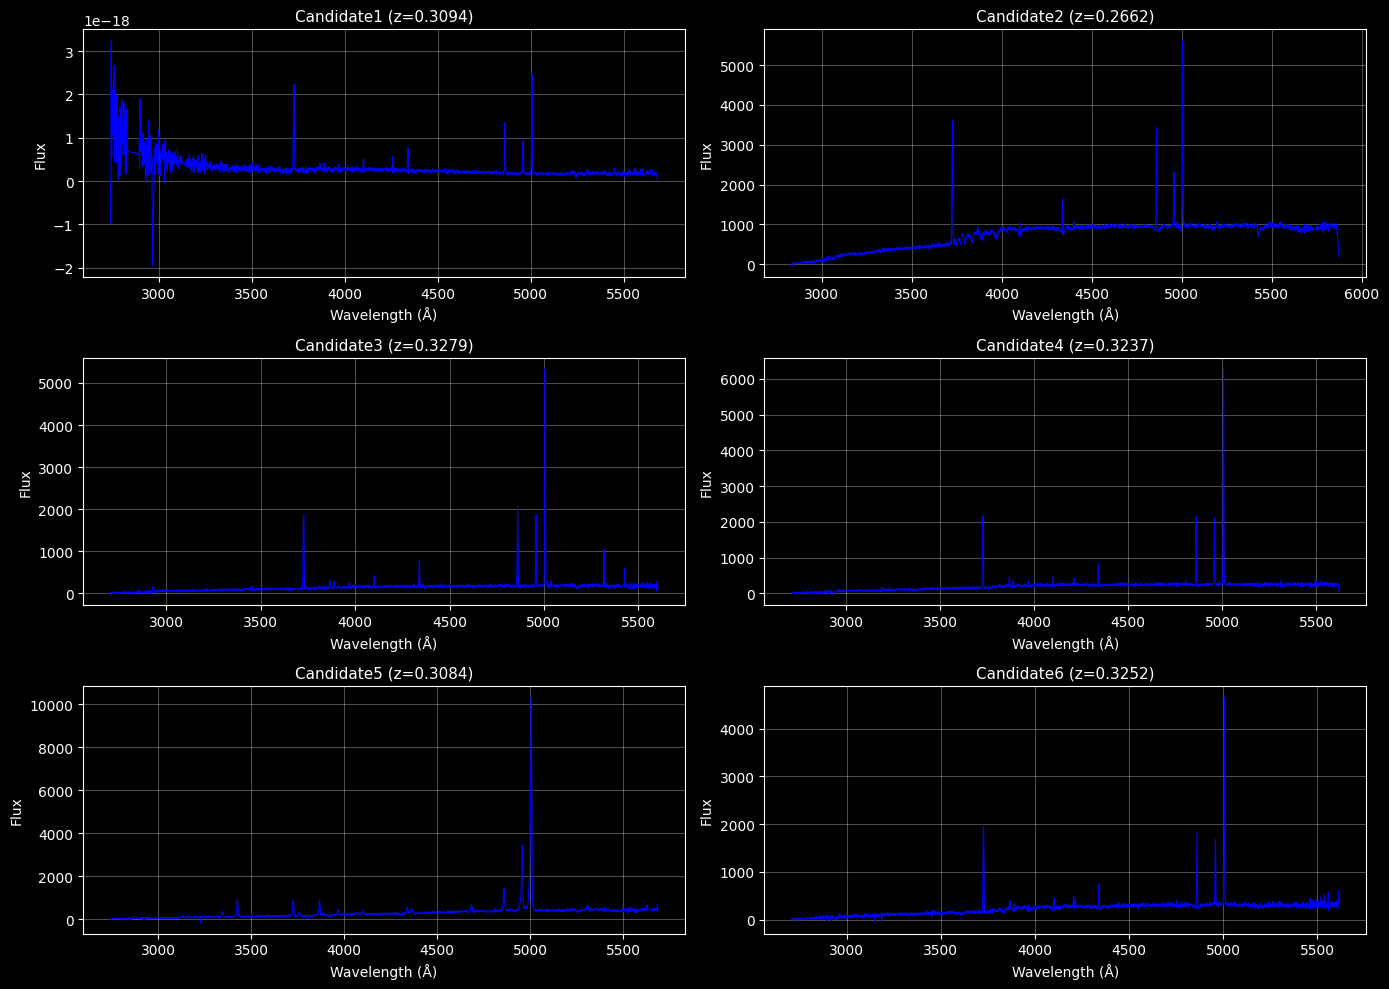

In [11]:
# Abrir os 6 espectros corrigidos e plotar
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (df_resampled, candidate_name) in enumerate(zip(df_resampled_all, redshifts.keys())):
    z = redshifts[candidate_name]
    
    # Plotar o espectro
    axes[i].plot(df_resampled['wavelength'], df_resampled['flux'], linewidth=0.8, color='blue')
    axes[i].set_xlabel('Wavelength (Å)', fontsize=10)
    axes[i].set_ylabel('Flux', fontsize=10)
    axes[i].set_title(f'{candidate_name} (z={z})', fontsize=11)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Salvar os espectros reamostrados como arquivos .spec (sem cabeçalho, separados por espaço)
output_dir_spec = '/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/'

for i, (df_resampled, candidate_name) in enumerate(zip(df_resampled_all, redshifts.keys())):
    # Criar nome do arquivo .spec
    output_path_spec = os.path.join(output_dir_spec, f'{candidate_name}_corrected.spec')
    
    # Salvar sem cabeçalho, separado por espaço
    df_resampled.to_csv(output_path_spec, sep=' ', index=False, header=False, float_format='%.6e')
    
    print(f"{candidate_name} → Salvo em: {output_path_spec}")

print("\nArquivos .spec salvos com sucesso!")

Candidate1 → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate1_corrected.spec
Candidate2 → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate2_corrected.spec
Candidate3 → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate3_corrected.spec
Candidate4 → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate4_corrected.spec
Candidate5 → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/specs_correct/Candidate5_corrected.spec
Candidate6

# Vars nos Espectros

In [22]:
def read_specs_gemini_var(path_arq):
    data_fits = fits.open(path_arq)
    
    # Tentar ler da extensão VAR (índice 2 nos arquivos originais)
    if len(data_fits) > 2 and data_fits[2].header.get('EXTNAME') == 'VAR':
        var_data = data_fits[2].data
        header = data_fits[2].header
    # Se não, tentar a extensão 1 (pode ser um arquivo só com variância)
    elif len(data_fits) > 1:
        var_data = data_fits[1].data
        header = data_fits[1].header
    # fallback para a extensão primária
    else:
        var_data = data_fits[0].data
        header = data_fits[0].header

    # CORREÇÃO DO BUG (NumPy 2.0): Converter big-endian para little-endian
    if var_data.dtype.byteorder == '>': # Se for big-endian
        var_data = var_data.byteswap().view(var_data.dtype.newbyteorder('<'))
    
    # Calcular wavelength usando o header (assumindo que é o mesmo do SCI)
    naxis1 = header['NAXIS1']
    crval1 = header['CRVAL1']
    crpix1 = header['CRPIX1']
    cdelt1 = header['CDELT1']
    
    pix = np.arange(naxis1)
    lam = crval1 + (pix - crpix1) * cdelt1

    # O erro é a raiz quadrada da variância
    error = np.sqrt(np.abs(var_data))

    df_create = pd.DataFrame({'wavelength': lam, 'var': var_data, 'error': error})
    
    data_fits.close()
    return df_create

# Caminhos para os arquivos FITS originais que contêm a extensão VAR
caminho_spec_var = [f'/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/vars/var_candidate_{i}.fits' for i in range(1, 7)]

df_spec_var = [read_specs_gemini_var(caminho) for caminho in caminho_spec_var]

# Converter 'wavelength' de nm para Angstroms
for df in df_spec_var:
    df['wavelength'] = df['wavelength'] * 10


In [14]:
# Reamostrar os espectros de variância usando a mesma grid
df_resampled_var_all = []

output_dir = fr"/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/vars_correct"

print("Reamostrando variâncias para a mesma grid...\n")

for i, (df_var, candidate_name) in enumerate(zip(df_spec_var, redshifts.keys())):
    z = redshifts[candidate_name]
    
    print(f"Processando variância {candidate_name} (z={z})...")
    
    # Reamostrar usando a função existente, passando 'var' como coluna de variância
    df_var_resampled = resample_spectrum(
        df_var,
        z=z,
        new_wavelength_grid=new_wavelength_grid,
        flux_col='error',  # Usar 'error' como flux para reamostragem
        var_col='var'      # Processar a variância
    )
    
    df_resampled_var_all.append(df_var_resampled)
    
    # Salvar o arquivo de variância reamostrada
    output_path_var = os.path.join(output_dir, f'{candidate_name}_var_corrected.csv')
    df_var_resampled.to_csv(output_path_var, sep='\t', index=False, float_format='%.6e')
    
    print(f"  → Salvo em: {output_path_var}\n")

print("Processo de reamostragem de variâncias concluído!")


Reamostrando variâncias para a mesma grid...

Processando variância Candidate1 (z=0.3094)...


        Use Spectrum instead. [warnings]
/home/pierre/anaconda3/envs/main/lib/python3.13/site-packages/specutils/manipulation/resample.py:217: RuntimeWarning: divide by zero encountered in reciprocal
  output_errs = InverseVariance(np.reciprocal(output_errs))


  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/vars_correct/Candidate1_var_corrected.csv

Processando variância Candidate2 (z=0.2662)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/vars_correct/Candidate2_var_corrected.csv

Processando variância Candidate3 (z=0.3279)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/vars_correct/Candidate3_var_corrected.csv

Processando variância Candidate4 (z=0.3237)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_1D_reduzidos/vars_correct/Candidate4_var_corrected.csv

Processando variância Candidate5 (z=0.3084)...
  → Salvo em: /home/pierre/pierre/Documents/

# Unir spec e var

In [42]:
# Unir os DataFrames de fluxo e variância antes de reamostrar
df_spec_full = []
for flux_df, var_df in zip(df_spec_gemini_corrected, df_spec_var):
    merged_df = pd.merge_asof(
        flux_df.sort_values('wavelength'),
        var_df[['wavelength', 'var']].sort_values('wavelength'),
        on='wavelength',
        direction='nearest'
    )
    df_spec_full.append(merged_df)

# Agora, reamostre usando o DataFrame completo
df_resampled_all = []
output_dir_final = '/home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_finais_resampled/'
os.makedirs(output_dir_final, exist_ok=True)

for i, (df, candidate_name) in enumerate(zip(df_spec_full, redshifts.keys())):
    z = redshifts[candidate_name]
    print(f"Processando {candidate_name} (z={z})...")
    
    # Chame a função passando 'flux' como fluxo e 'var' como variância
    df_resampled = resample_spectrum(
        df,
        z=z,
        new_wavelength_grid=new_wavelength_grid,
        flux_col='flux',  # Coluna de fluxo real
        var_col='var'     # Coluna de variância real
    )
    
    df_resampled_all.append(df_resampled)
    
    # Salvar o arquivo final com tudo reamostrado corretamente
    output_path = os.path.join(output_dir_final, f'{candidate_name}_final.csv')
    df_resampled.to_csv(output_path, sep='\t', index=False, float_format='%.6e')
    print(f"  → Salvo em: {output_path}\n")

print("Processo de reamostragem unificada concluído!")

Processando Candidate1 (z=0.3094)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_finais_resampled/Candidate1_final.csv

Processando Candidate2 (z=0.2662)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_finais_resampled/Candidate2_final.csv

Processando Candidate3 (z=0.3279)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_finais_resampled/Candidate3_final.csv

Processando Candidate4 (z=0.3237)...


        Use Spectrum instead. [warnings]


  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_finais_resampled/Candidate4_final.csv

Processando Candidate5 (z=0.3084)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_finais_resampled/Candidate5_final.csv

Processando Candidate6 (z=0.3252)...
  → Salvo em: /home/pierre/pierre/Documents/Faculdade_iag/main_doc/Dados/Reducao_espectros/Proposal_compact_halpha_candidates/espectros_finais_resampled/Candidate6_final.csv

Processo de reamostragem unificada concluído!


In [44]:
for df in df_resampled_all:
    # Criar a coluna 'flag' com valor padrão 0
    df['flag'] = 0
    
    # Identificar condições para a flag = 99 (erro zero, infinito ou NaN)
    error_is_problematic = (df['error'] == 0) | np.isinf(df['error']) | np.isnan(df['error'])
    
    # Atribuir 99 à flag onde as condições são verdadeiras
    df.loc[error_is_problematic, 'flag'] = 99
    
    # Substituir valores 'inf' e '-inf' por 0.0
    df.replace([np.inf, -np.inf], 0.0, inplace=True)
    
    # Preencher quaisquer valores NaN restantes com 0.0
    df.fillna(0.0, inplace=True)

# Selecionar e reordenar as colunas para o formato final
df_final = [df[['wavelength', 'flux', 'var', 'error', 'flag']].copy() for df in df_resampled_all]

# Verificação final (opcional, mas recomendada)
print("Verificando se há valores não finitos nos DataFrames finais...")
for i, df in enumerate(df_final):
    if not np.all(np.isfinite(df)):
        print(f"  Aviso: O espectro {i+1} ainda contém valores não finitos!")
    else:
        print(f"  Espectro {i+1}: OK")


# Salvar os espectros processados em formato .spec para uso no STARLIGHT

output_dir = "/home/pierre/starlight/STARLIGHTv06/obs_dir/"

for i, df in enumerate(df_final, start=1):
    # Criar nome do arquivo
    filename = f"{output_dir}{i}_BCD.spec"
    
    # Salvar com formato compatível com STARLIGHT
    # Formato: wavelength flux error flag, colunas separadas por um espaço
    df.to_csv(filename, sep=' ', index=False, header=False)
    
    print(f"Espectro {i} salvo em: {filename}")

Verificando se há valores não finitos nos DataFrames finais...
  Espectro 1: OK
  Espectro 2: OK
  Espectro 3: OK
  Espectro 4: OK
  Espectro 5: OK
  Espectro 6: OK
Espectro 1 salvo em: /home/pierre/starlight/STARLIGHTv06/obs_dir/1_BCD.spec
Espectro 2 salvo em: /home/pierre/starlight/STARLIGHTv06/obs_dir/2_BCD.spec
Espectro 3 salvo em: /home/pierre/starlight/STARLIGHTv06/obs_dir/3_BCD.spec
Espectro 4 salvo em: /home/pierre/starlight/STARLIGHTv06/obs_dir/4_BCD.spec
Espectro 5 salvo em: /home/pierre/starlight/STARLIGHTv06/obs_dir/5_BCD.spec
Espectro 6 salvo em: /home/pierre/starlight/STARLIGHTv06/obs_dir/6_BCD.spec
